# Chapter 12 IP WEIGHTING AND MARGINAL STRUCTURAL MODELS

## Introduction

https://en.wikipedia.org/wiki/Inverse_probability_weighting

Inverse probability weighting is a statistical technique for estimating quantities related to a population other than the one from which the data was collected. Study designs with a disparate sampling population and population of target inference (target population) are common in application.

https://en.wikipedia.org/wiki/Marginal_structural_model

Marginal structural models are a class of statistical models used for causal inference in epidemiology. Such models handle the issue of time-dependent confounding in evaluation of the efficacy of interventions by inverse probability weighting for receipt of treatment, they allow us to estimate the average causal effects.

## Functions

> Here we assume that the following 9 variables, all measured at baseline, are sufficient to adjust for confounding: sex (0: male, 1: female), age (in years), race (0: white, 1: other), education (5 categories), intensity and duration of smoking (number of cigarettes per day and years of smoking), physical activity in daily life (3 categories), recreational exercise (3 categories), and weight (in kg).

In [ ]:
from scipy.stats import norm
import statsmodels.api as sm
from formulaic import model_matrix
import pandas as pd
import numpy as np
from statsmodels.genmod.generalized_estimating_equations import GEE

cont_vars = [
    "age", "age_sq", "wt71", "wt71_sq",
    "smokeintensity", "smokeintensity_sq", "smokeyrs", "smokeyrs_sq"
]

cat_vars = ["sex", "race", "education", "exercise", "active"]

covariates = cat_vars + cont_vars

def load_nhefs():
    # https://wwwn.cdc.gov/nchs/nhanes/nhefs/
    url = 'https://miguelhernan.org/s/nhefs.csv'
    df = pd.read_csv(url)

    for var in cat_vars:
        df[var] = df[var].astype('category')

    df = add_raw_quadratics(df, ["age", "wt71", "smokeintensity", "smokeyrs"])

    return df

def compute_ip_weights_formula(df, rhs_formula, treatment='A', stabilized=True):
    X_cov = model_matrix(rhs_formula, df)
    X_den = sm.add_constant(X_cov).astype(float)
    p_den = sm.Logit(df[treatment], X_den).fit(disp=False).predict(X_den)
    p_num = df[treatment].mean()
    if stabilized:
        return np.where(df[treatment] == 1, p_num / p_den, (1 - p_num) / (1 - p_den))
    else:
        return np.where(df[treatment] == 1, 1 / p_den, 1 / (1 - p_den))

def compute_ip_weights_manual(df, treatment="A", stabilized=False, cont_vars=cont_vars, cat_vars=cat_vars):
    # Ensure raw squares are already present in cont_vars
    X_cont = df[cont_vars]
    X_cat = pd.get_dummies(df[cat_vars], drop_first=True)
    X_den = sm.add_constant(pd.concat([X_cont, X_cat], axis=1), has_constant='add').astype(float)

    # Fit logistic model: P(A | L)
    p_den = sm.Logit(df[treatment], X_den).fit(disp=0).predict()

    if stabilized:
        # Numerator: marginal P(A)
        p_num = df[treatment].mean()
        return np.where(df[treatment] == 1, p_num / p_den, (1 - p_num) / (1 - p_den))
    else:
        # Non-stabilized weights
        return np.where(df[treatment] == 1, 1 / p_den, 1 / (1 - p_den))

def fit_msm_wls(df, outcome="Y", treatment="A", weight="w", alpha=0.05):
    X = sm.add_constant(df[treatment])
    Y = df[outcome]
    W = df[weight]
    model = sm.WLS(Y, X, weights=W).fit()
#    model = sm.WLS(Y, X, weights=W).fit(cov_type="HC0")
    theta1, se = model.params[treatment], model.bse[treatment]
    z = norm.ppf(1 - alpha / 2)
    return theta1, theta1 - z * se, theta1 + z * se

def fit_msm_gee(df, outcome="Y", treatment="A", weight="w", alpha=0.05):
    X = sm.add_constant(df[treatment]).to_numpy()
    y = df[outcome].to_numpy()
    w = df[weight].to_numpy()
    model = GEE(y, X, groups=df.index.to_numpy(), weights=w).fit()
    theta1, se = model.params[1], model.bse[1]
    z = norm.ppf(1 - alpha / 2)
    return theta1, theta1 - z * se, theta1 + z * se

def add_raw_quadratics(df, vars):
    for v in vars:
        df[f"{v}_sq"] = df[v]**2
    return df

## Data

> For this and future chapters, we will use a subset of the NHEFS data that is available from this book’s web site.

In [25]:
df = load_nhefs()

In [26]:
df.shape

(1629, 68)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   seqn               1629 non-null   int64   
 1   qsmk               1629 non-null   int64   
 2   death              1629 non-null   int64   
 3   yrdth              318 non-null    float64 
 4   modth              322 non-null    float64 
 5   dadth              322 non-null    float64 
 6   sbp                1552 non-null   float64 
 7   dbp                1548 non-null   float64 
 8   sex                1629 non-null   category
 9   age                1629 non-null   int64   
 10  race               1629 non-null   category
 11  income             1567 non-null   float64 
 12  marital            1629 non-null   int64   
 13  school             1629 non-null   int64   
 14  education          1629 non-null   category
 15  ht                 1629 non-null   float64 
 16  wt71  

> Our goal is to estimate the average causal effect of smoking cessation (the treatment) A on weight gain (the outcome) Y. To do so, we will use data from 1566 cigarette smokers aged 25-74 years who, as part of the NHEFS, had a baseline and follow-up visit about 10 years later.

In [28]:
df[df['wt82'].notna()].shape

(1566, 68)

## Questions

- Q1: Estimate the causal effect reported in section 12.2, θ^1=3.4 and the 95% CI: (2.4, 4.5) using the IP weights described in the same section
- Q2: Summarize and plot the estimated IP weights by treatment level
- Q3: Reproduce the results of section 12.3 using stabilized IP weights
- Q4: Summarize and plot the estimated stabilized IP weights by treatment level
- Q5: Reproduce the causal effect of quitting smoking on weight gain estimated in section 12.6 using stabilized IP weights for treatment and censoring
- Q6: What are the means and distributions of the stabilized IP weights $SW^A,C$ in each treatment group?
- Q7: Reproduce the analysis in section 12.4 in which the treatment is the continuous variable “change in smoking intensity” (smkintensity82_71).

- Q1 (Binary treatment → outcome)
- Q3/Q5 (Treatment + Censoring)
- Q7 (Continuous treatment)

### Q1: Estimate the causal effect reported in section 12.2, θ^1=3.4 and the 95% CI: (2.4, 4.5) using the IP weights described in the same section

Estimate the average treatment effect of quitting smoking on weight gain using non-stabilized IP weights and a marginal structural model.

```mermaid
graph TD
  L[Covariates: age, sex, education, etc.] --> A[Treatment: qsmk]
  L --> Y[Outcome: wt82_71]
  A --> Y
```

Below four different solutions:
- 1.1 WLS + formulaic
- 1.2 GEE + formulaic
- 1.3 WLS + manual
- 1.4 GEE + manual

#### 1.1 WLS + formulaic

In [29]:
### 1.1 WLS

df = load_nhefs()
df = df[df["wt82"].notna()].copy()
df["A"] = df["qsmk"].astype(int)
df["Y"] = df["wt82_71"]

rhs = (
    "C(sex) + C(race) + C(education) + C(exercise) + C(active) + "
    "poly(age, 2) + poly(wt71, 2) + poly(smokeintensity, 2) + poly(smokeyrs, 2)"
)

df["w"] = compute_ip_weights_formula(df, rhs, stabilized=False)
theta1, ci_lower, ci_upper = fit_msm_wls(df)
print(f"θ¹ = {theta1:.2f} kg   |   95 % CI: ({ci_lower:.2f}, {ci_upper:.2f}) kg")


θ¹ = 3.44 kg   |   95 % CI: (2.64, 4.24) kg


#### 1.2 GEE + formulaic

In [30]:
### 1.2 GEE

df = load_nhefs()
df = df[df["wt82"].notna()].copy()
df["A"] = df["qsmk"].astype(int)
df["Y"] = df["wt82_71"]

rhs = (
    "C(sex) + C(race) + C(education) + C(exercise) + C(active) + "
    "poly(age,2) + poly(wt71,2) + poly(smokeintensity,2) + poly(smokeyrs,2)"
)

df["w"] = compute_ip_weights_formula(df, rhs, stabilized=False)
theta1, ci_lower, ci_upper = fit_msm_gee(df)
print(f"θ¹ = {theta1:.2f} kg   |   95 % CI: ({ci_lower:.2f}, {ci_upper:.2f}) kg")


θ¹ = 3.44 kg   |   95 % CI: (2.41, 4.47) kg


#### 1.3 WLS + manual

In [31]:
### 1.3 WLS

df = load_nhefs()
df = df[df['wt82'].notna()].copy()
df['A'] = df['qsmk']
df['Y'] = df['wt82_71']

# Compute stabilized weights
df["w"] = compute_ip_weights_manual(df, stabilized=False)

# Fit MSM via WLS
theta1, ci_lower, ci_upper = fit_msm_wls(df)
print(f"θ¹ = {theta1:.2f} kg   |   95 % CI: ({ci_lower:.2f}, {ci_upper:.2f}) kg")

θ¹ = 3.44 kg   |   95 % CI: (2.64, 4.24) kg


#### 1.4 GEE + manual

In [32]:
### 1.4

df = load_nhefs()
df = df[df["wt82"].notna()].copy()
df["A"] = df["qsmk"]
df["Y"] = df["wt82_71"]

# Compute stabilized weights using raw powers and treatment-coded dummies
df["w"] = compute_ip_weights_manual(df, stabilized=False)

# Fit MSM via GEE
theta1, ci_lower, ci_upper = fit_msm_gee(df)
print(f"θ¹ = {theta1:.2f} kg   |   95 % CI: ({ci_lower:.2f}, {ci_upper:.2f}) kg")

θ¹ = 3.44 kg   |   95 % CI: (2.41, 4.47) kg


### Q2: Summarize and plot the estimated IP weights by treatment level

Visualize the distribution of non-stabilized IP weights and summarize their range and variability across treatment groups.

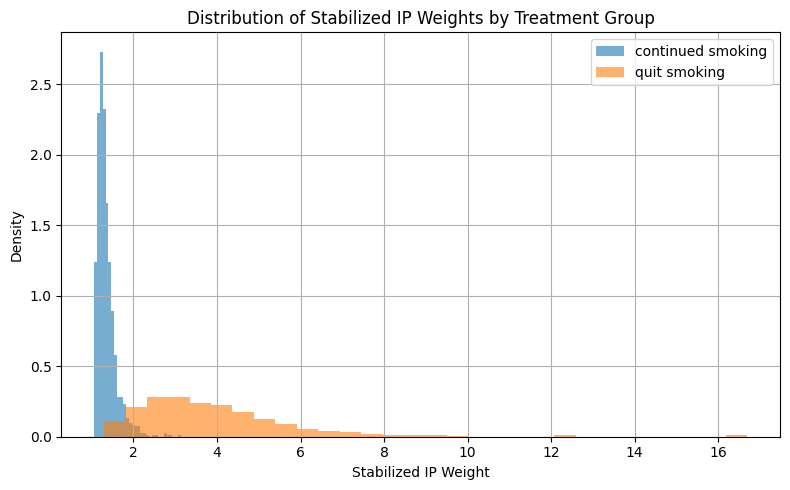

,count,mean,std,min,25%,50%,75%,max
qsmk,,,,,,,,
0,1163.0,1.345964,0.235053,1.053742,1.195463,1.284785,1.426419,3.139673
1,403.0,3.873013,1.885008,1.287186,2.581397,3.541739,4.645631,16.700094


In [ ]:
import matplotlib.pyplot as plt

# Plot distribution of weights by treatment group
plt.figure(figsize=(8, 5))
for a_value, label in zip([0, 1], ['continued smoking', 'quit smoking']):
    plt.hist(df[df['A'] == a_value]['w'], bins=30, alpha=0.6, label=label, density=True)

plt.xlabel("IP Weight")
plt.ylabel("Density")
plt.title("Distribution of IP Weights by Treatment Group")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summarize IP weights by treatment group
df.groupby('qsmk')['w'].describe()

### Q3: Reproduce the results of section 12.3 using stabilized IP weights

Recalculate the treatment weights using the stabilized formula `SW = f(A) / f(A|L)`, fit the MSM, and compare with the non-stabilized version.

```mermaid
graph TD
  L[Covariates] --> A[Treatment: qsmk]
  L --> Y[Outcome: wt82_71]
  L --> C[Censoring]
  A --> Y
  A --> C
```

To reproduce the results of Section 12.3, we estimate **stabilized inverse probability (IP) weights**, defined as:

$$
SW_i = \frac{\hat{f}(A_i)}{\hat{f}(A_i \mid L_i)}
$$

where:
- $A_i$ is the observed treatment for individual $i$
- $L_i$ is the vector of baseline covariates for individual $i$,
- $\hat{f}(A_i)$ is the **marginal probability** of treatment,
- $\hat{f}(A_i \mid L_i)$ is the **conditional probability** of treatment given covariates (estimated via logistic regression).

These stabilized weights reduce variance compared to non-stabilized weights, while still achieving exchangeability in the weighted pseudo-population.

In [ ]:
### Q3: Reproduce results of section 12.3 using stabilized IP weights

df = load_nhefs()
df = df[df["wt82"].notna()].copy()

# Compute stabilized weights manually
df["sw"] = compute_ip_weights_manual(df, stabilized=True)

# Fit weighted model E[Y | A] = θ₀ + θ₁ A
theta1, ci_lower, ci_upper = fit_msm_wls(df, weight='sw')

print(f"θ¹ = {theta1:.2f} kg   |   95 % CI: ({ci_lower:.2f}, {ci_upper:.2f}) kg")

θ¹ = 3.44 kg   |   95 % CI: (2.56, 4.32) kg


### Q4: Summarize and plot the estimated stabilized IP weights by treatment level

Compare the distribution and summary statistics of the stabilized weights across treatment groups. Evaluate weight variability and balance.

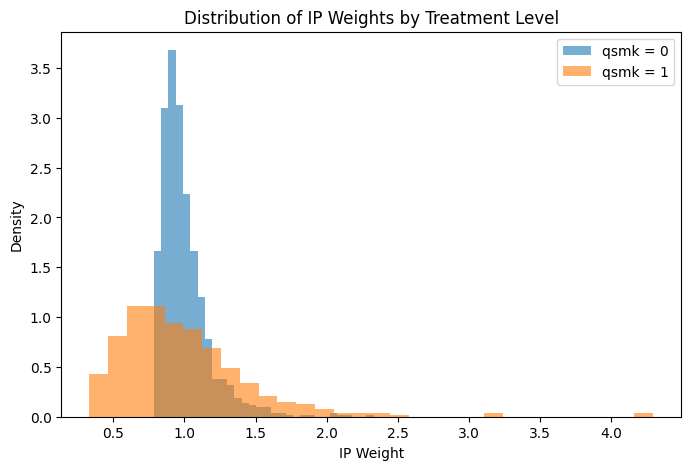

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
for value in sorted(df['qsmk'].unique()):
    subset = df[df['qsmk'] == value]['sw']
    ax.hist(subset, bins=30, alpha=0.6, label=f'qsmk = {value}', density=True)

ax.set_title('Distribution of IP Weights by Treatment Level')
ax.set_xlabel('IP Weight')
ax.set_ylabel('Density')
ax.legend()
plt.show()

### Q5: Reproduce the causal effect of quitting smoking on weight gain estimated in section 12.6 using stabilized IP weights for treatment and censoring

Estimate the ATE accounting for both treatment assignment and loss to follow-up by constructing and multiplying stabilized treatment and censoring weights.

```mermaid
graph TD
  L[Covariates] --> A[Treatment: qsmk]
  L --> Y[Outcome: wt82_71]
  L --> C[Censoring]
  A --> Y
  L --> Y
  A --> C
```

To reproduce the results of Section 12.6, we estimate the **causal effect of quitting smoking on weight gain** using stabilized inverse probability weights for both **treatment** and **censoring**.

We define:

- $SW^A_i = \frac{\hat{f}(A_i)}{\hat{f}(A_i \mid L_i)}$ — stabilized weight for treatment
- $SW^C_i = \frac{\hat{f}(C_i = 0 \mid A_i)}{\hat{f}(C_i = 0 \mid A_i, L_i)}$ — stabilized weight for censoring

We then combine them:

$$
SW^{A,C}_i = SW^A_i \cdot SW^C_i
$$

We apply these weights to uncensored individuals and fit a weighted model:

$$
E[Y_i \mid A_i] = \theta_0 + \theta_1 A_i
$$

This provides an estimate of the causal effect of quitting smoking on weight gain, assuming conditional exchangeability.

In [51]:
import warnings
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning, ConvergenceWarning


df["cens"] = df["wt82"].isna().astype(int)

# Stabilized treatment weights
sw_a = compute_ip_weights_manual(df, treatment="qsmk", stabilized=True)

# Stabilized censoring weights
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=PerfectSeparationWarning)
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    sw_c = compute_ip_weights_manual(df, treatment="cens", stabilized=True)

# Combined weight and subsetting to uncensored
df["sw_ac"] = sw_a * sw_c
df_unc = df[df["cens"] == 0]

# Fit marginal structural model
theta1, ci_lower, ci_upper = fit_msm_wls(df_unc, weight="sw_ac", treatment='qsmk', outcome='wt82_71')
print(f"θ¹ = {theta1:.2f} kg   |   95 % CI: ({ci_lower:.2f}, {ci_upper:.2f}) kg")


θ¹ = 3.44 kg   |   95 % CI: (2.56, 4.32) kg


### Q6: What are the means and distributions of the stabilized IP weights

After computing combined stabilized weights (for treatment and censoring), evaluate their range and summary statistics stratified by treatment.

,count,mean,std,min,25%,50%,75%,max
qsmk,,,,,,,,
continued smoking,1163.0,0.999589,0.174563,0.782568,0.887818,0.954154,1.059340,2.331699
quit smoking,403.0,0.996695,0.485095,0.331249,0.664306,0.911444,1.195523,4.297662


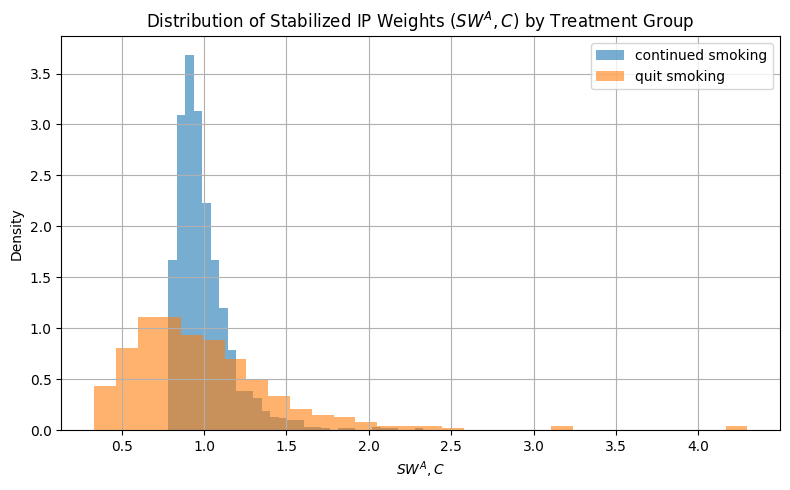

In [52]:
import matplotlib.pyplot as plt

# Summary table
summary_sw_ac = df.groupby('qsmk')['sw_ac'].describe().rename(index={0: 'continued smoking', 1: 'quit smoking'})
display(summary_sw_ac)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
for group, label in zip([0, 1], ['continued smoking', 'quit smoking']):
    ax.hist(df[df['qsmk'] == group]['sw_ac'], bins=30, alpha=0.6, label=label, density=True)

ax.set_title('Distribution of Stabilized IP Weights ($SW^A,C$) by Treatment Group')
ax.set_xlabel('$SW^A,C$')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### Q7: Reproduce the analysis in section 12.4 in which the treatment is the continuous variable “change in smoking intensity” (smkintensity82_71).

Estimate the effect of a continuous exposure (`smkintensity82_71`) on weight change using a marginal structural model with continuous treatment.

```mermaid
graph TD
  L[Covariates] --> A[Change in smoking intensity]
  L --> Y[Weight change]
  A --> Y
```

> Let us say that we are interested in estimating the difference in average weight change under different changes in treatment intensity in the 1162 individuals who smoked 25 or fewer cigarettes per day at baseline.

We estimate a marginal structural model for a continuous treatment:

$$
E[Y_a] = \beta_0 + \beta_1 a + \beta_2 a^2
$$

where:

- $a = \texttt{smkintensity82\_71}$, the change in smoking intensity between 1971 and 1982
- $Y_a = \texttt{wt82\_71}$, the weight change had everyone received treatment level $a$

The parameters $\beta_0, \beta_1, \beta_2$ are estimated using inverse probability weighting with:

$$
\text{SW}^A_i = \frac{f(A_i)}{f(A_i \mid L_i)} = \frac{\phi(A_i; \mu_0, \sigma_0)}{\phi(A_i; \mu_i, \sigma)}
$$

where $\phi(\cdot; \mu, \sigma)$ is the normal PDF,  
$\mu_0$ and $\sigma_0$ come from the marginal model,  
$\mu_i$ and $\sigma$ from the conditional model given covariates $L_i$.

In [53]:
# Restrict to individuals who smoked ≤25 cigarettes/day at baseline
df = load_nhefs()
df["cens"] = df["wt82"].isna().astype(int)
df = df[df['wt82'].notna()].copy()

df7 = df[df['smokeintensity'] <= 25].copy()

df7['smkintensity82_71_sq'] = df7['smkintensity82_71'] ** 2

y = df7['smkintensity82_71']

# Fit denominator model (conditional density)
X_den = sm.add_constant(df7[covariates])
model_den = sm.OLS(y, X_den).fit()
mu_den = model_den.fittedvalues
sigma_den = model_den.resid.std()
dens_den = norm.pdf(y, loc=mu_den, scale=sigma_den)

# Fit numerator model (marginal)
X_num = sm.add_constant(np.ones(len(df7)))
model_num = sm.OLS(y, X_num).fit()
mu_num = model_num.fittedvalues
sigma_num = model_num.resid.std()
dens_num = norm.pdf(y, loc=mu_num, scale=sigma_num)

# Calculate stabilized weights
df7['sw_a'] = dens_num / dens_den

# Fit MSM with stabilized weights
X_msm = sm.add_constant(df7[['smkintensity82_71', 'smkintensity82_71_sq']])
y_msm = df7['wt82'] - df7['wt71']
y_msm = df7['wt82_71']
model_msm = sm.WLS(y_msm, X_msm, weights=df7['sw_a']).fit()

# Compute 95% CI
beta = model_msm.params
se = model_msm.bse
z = norm.ppf(0.975)
ci_lower = beta - z * se
ci_upper = beta + z * se

results = pd.DataFrame({
    "coef": model_msm.params,
    "CI lower": ci_lower,
    "CI upper": ci_upper
}).round(4)

print(results)

                        coef  CI lower  CI upper
const                 2.0678    1.5439    2.5916
smkintensity82_71    -0.1108   -0.1530   -0.0686
smkintensity82_71_sq  0.0020   -0.0000    0.0040


In [54]:
# Use estimated coefficients to compute E[Y_{a=0}] and E[Y_{a=20}]
a0 = 0
a20 = 20

E_Y_a0 = beta['const'] + beta['smkintensity82_71'] * a0 + beta['smkintensity82_71_sq'] * (a0 ** 2)
E_Y_a20 = beta['const'] + beta['smkintensity82_71'] * a20 + beta['smkintensity82_71_sq'] * (a20 ** 2)
causal_effect = E_Y_a0 - E_Y_a20

print(f"E[Y_a=0]  = {E_Y_a0:.2f} kg")
print(f"E[Y_a=20] = {E_Y_a20:.2f} kg")
print(f"Causal effect (E[Y_0] - E[Y_20]) = {causal_effect:.2f} kg")

E[Y_a=0]  = 2.07 kg
E[Y_a=20] = 0.65 kg
Causal effect (E[Y_0] - E[Y_20]) = 1.42 kg


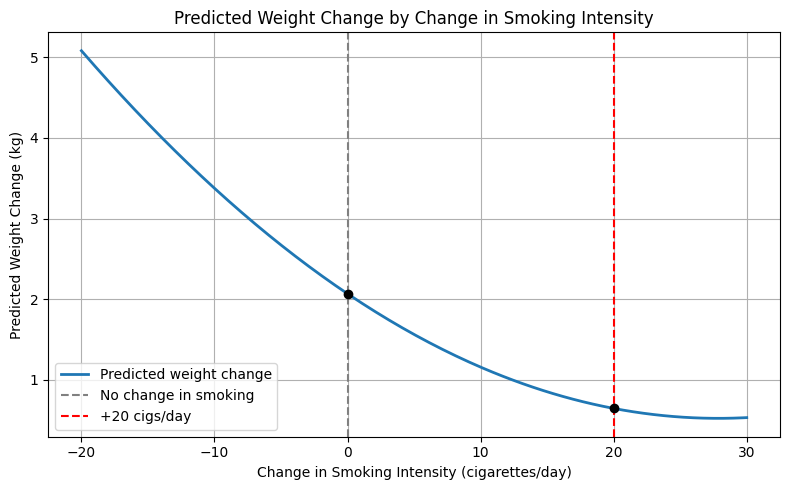

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a range of a values
a_vals = np.linspace(-20, 30, 200)
y_vals = beta['const'] + beta['smkintensity82_71'] * a_vals + beta['smkintensity82_71_sq'] * (a_vals ** 2)

plt.figure(figsize=(8, 5))
plt.plot(a_vals, y_vals, label='Predicted weight change', lw=2)
plt.axvline(0, color='gray', linestyle='--', label='No change in smoking')
plt.axvline(20, color='red', linestyle='--', label='+20 cigs/day')
plt.scatter([0, 20], [
    beta['const'] + beta['smkintensity82_71'] * 0 + beta['smkintensity82_71_sq'] * (0 ** 2),
    beta['const'] + beta['smkintensity82_71'] * 20 + beta['smkintensity82_71_sq'] * (20 ** 2)
], color='black', zorder=5)
plt.title("Predicted Weight Change by Change in Smoking Intensity")
plt.xlabel("Change in Smoking Intensity (cigarettes/day)")
plt.ylabel("Predicted Weight Change (kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


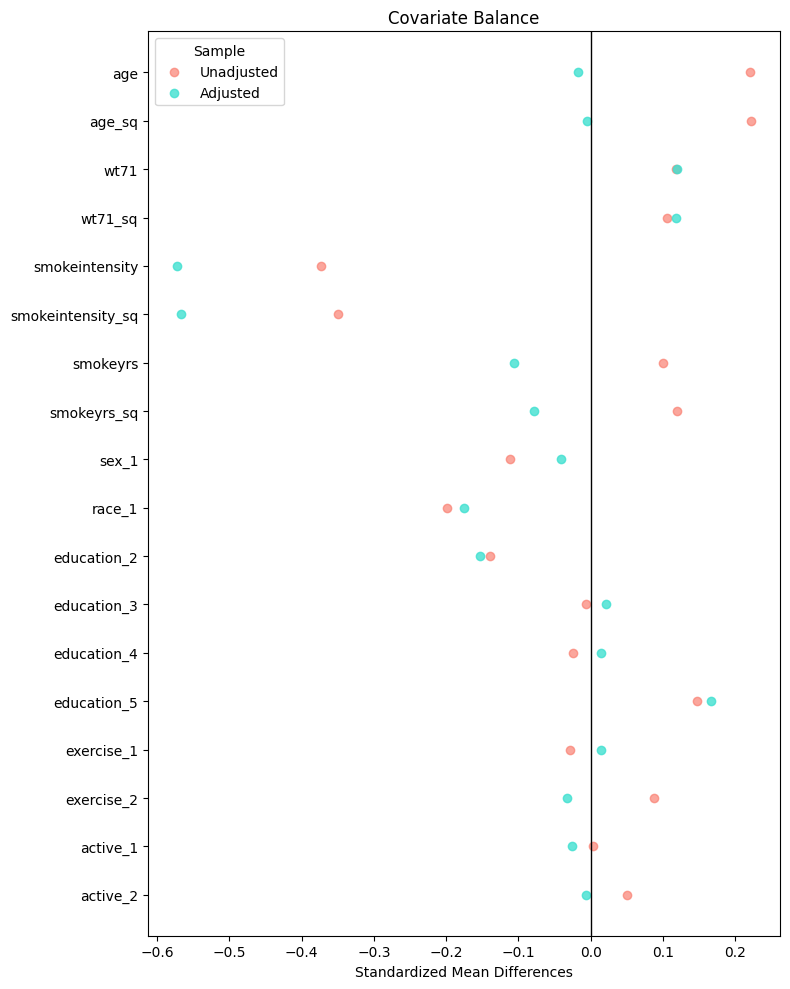

In [56]:
import matplotlib.pyplot as plt

def compute_smd(df, covariates, treatment, weights=None):
    smd = {}

    # Convert categorical variables to dummies (drop first to avoid collinearity)
    df_encoded = pd.get_dummies(df[covariates], drop_first=True)
    covariate_names = df_encoded.columns

    treated = df[df[treatment] == 1].copy()
    control = df[df[treatment] == 0].copy()

    for var in covariate_names:
        x_treated = df_encoded.loc[treated.index, var]
        x_control = df_encoded.loc[control.index, var]

        if weights is None:
            m1, m0 = x_treated.mean(), x_control.mean()
            s1, s0 = x_treated.std(), x_control.std()
        else:
            w = df[weights]
            w_treated = w.loc[treated.index]
            w_control = w.loc[control.index]
            m1 = np.average(x_treated, weights=w_treated)
            m0 = np.average(x_control, weights=w_control)
            s1 = np.sqrt(np.cov(x_treated, aweights=w_treated))
            s0 = np.sqrt(np.cov(x_control, aweights=w_control))

        pooled_sd = np.sqrt((s1**2 + s0**2) / 2)
        smd[var] = (m1 - m0) / pooled_sd if pooled_sd > 0 else np.nan

    return pd.Series(smd)

import matplotlib.pyplot as plt

def love_plot_dots(df, covariates, treatment="qsmk", weights="sw_a"):
    smd_unw = compute_smd(df, covariates, treatment)
    smd_w = compute_smd(df, covariates, treatment, weights=weights)

    covariates = smd_unw.index.tolist()
    y_pos = range(len(covariates))

    plt.figure(figsize=(8, 10))
    plt.scatter(smd_unw, y_pos, label="Unadjusted", color="salmon", alpha=0.7)
    plt.scatter(smd_w, y_pos, label="Adjusted", color="turquoise", alpha=0.8)

    plt.axvline(0, color="black", linewidth=1)
    plt.yticks(y_pos, covariates)
    plt.xlabel("Standardized Mean Differences")
    plt.title("Covariate Balance")
    plt.legend(title="Sample")
    plt.gca().invert_yaxis()  # match R's ordering
    plt.tight_layout()
    plt.show()



love_plot_dots(df7, covariates=covariates, treatment="qsmk", weights="sw_a")

---

## 12.1 The causal question

> We restricted the analysis to individuals with known sex, age, race, weight, height, education, alcohol use and intensity of smoking at the baseline (1971-75) and follow-up (1982) visits, and who answered the medical history questionnaire at baseline.